<a href="https://colab.research.google.com/github/Arindam2002/Abstract_simplifier/blob/main/Abstract_simplifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract Simplifier

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

## Check for a GPU

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0a5acd92-3f4c-7786-6625-0fb12602b879)


### Import the helper function script

In [2]:
! wget https://raw.githubusercontent.com/Arindam2002/tensorflow_learning/main/helper_functions.py

--2022-07-23 18:39:15--  https://raw.githubusercontent.com/Arindam2002/tensorflow_learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10857 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.60K  --.-KB/s    in 0s      

2022-07-23 18:39:16 (115 MB/s) - ‘helper_functions.py’ saved [10857/10857]



## Get data

Dataset on GitHub by the author: https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check the files in PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
# Start our experiments using the 20k dataset with numbers replaced by the @ symbol
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all of the filenames in the target directory
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

In [7]:
# Create a function to read the lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the lines of text as a list

    Args:
        filename: a string containing the target filepath.

        Returns:
            A list of strings with one string per line from the target filename.
    """

    with open(filename, "r") as f:
        return f.readlines()

In [8]:
# Read in the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[
    {
        'line_number': 0,
        'target': 'BACKGROUND',
        'text': "Emotional eating is associated with overeating and the development of obesity .\n"
        'total_lines': 11,
    },
    {
        'line_number': 1,
        'target': 'METHODS',
        'text': "A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n"
        'total_lines': 11,
    },
   ...
]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [10]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename)     # get all lines from filename
  abstract_lines = ""       # create an empty abstract
  abstract_samples = []     # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):      # check to see if the is an ID line
      abstract_id = line
      abstract_lines = ""       # reset the abstract string if the line is an ID line

    elif line.isspace():        # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines()     # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}      # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t")       # split target label from text 
        line_data["target"] = target_text_split[0]      # get target label
        line_data["text"] = target_text_split[1].lower()        # get target text and lower it
        line_data["line_number"] = abstract_line_number     # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1     # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data)      # add line data to abstract samples list

    else:       # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [11]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")   # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 398 ms, sys: 83.6 ms, total: 481 ms
Wall time: 483 ms


In [12]:
train_samples[:15]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

> Let's turn our list of dictionaries into pandas DataFrame's so we visualize them better.

In [13]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

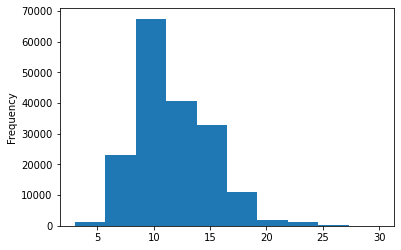

In [15]:
# Check length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [16]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [17]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [18]:
train_df["target"].to_numpy().reshape(-1, 1)

array([['OBJECTIVE'],
       ['METHODS'],
       ['METHODS'],
       ...,
       ['RESULTS'],
       ['CONCLUSIONS'],
       ['CONCLUSIONS']], dtype=object)

In [19]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)       # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [20]:
# Extract labels ("target columns") and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [21]:
# Get class names and no. of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a baseline

> TF-IDF Multinomial Naive Bayes classifier

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [24]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [25]:
# Import calculate_results function from helper function script
from helper_functions import calculate_results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

1. Vectorize
2. Embedding

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [28]:
# Length of each sentence (on an average)
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
avg_len = np.mean(sentence_lengths)
avg_len

26.338269273494777

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <a list of 30 Patch objects>)

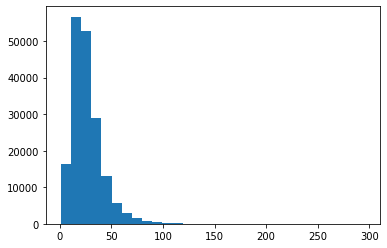

In [29]:
# Distribution of lengths
import matplotlib.pyplot as plt

plt.hist(sentence_lengths, bins=30)

In [30]:
# How long of a sentence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sentence_lengths, 95))
output_seq_len

55

#### Create text vectorizer layer

In [31]:
# Number of words in our vocab...(max_token) (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
MAX_TOKENS = 68000

In [32]:
# Create the text_vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=MAX_TOKENS,
                                    output_sequence_length=output_seq_len)

In [33]:
# Adapt the text_vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test a random sample text
import random

sample_text = random.choice(train_sentences)
print(f"Text:\n{sample_text}")
print(f"\nLength of the text: {len(sample_text.split())}")
print(f"\nVectorized Text:\n{text_vectorizer(sample_text)}")

Text:
time to starting oral liquids , soft diet and regular diet were decreased ( @ @ vs @ @ ; p < @ ; @ @ vs @ @ , p < @ and @ @ vs @ @ , p = @ ; respectively ) .

Length of the text: 47

Vectorized Text:
[   63     6  1470   217 13194  2484   376     3  1004   376     9   212
    44    14    44    14     3    44    14    83     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [35]:
# Number of words in our training vocabulary

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

#### Create custom text embedding

In [37]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),       # length of vocabulary
                               output_dim=128,      # Note: different embedding sizes result in drastically differnt numbers of parameters to train
                               mask_zero=True,      # use masking to handle variable sequence lengths (save space),
                               name="token_embedding")

In [38]:
# Show example embedding

print(f"Sentence before vectorization:\n {sample_text}\n")

vectorized_sentence = text_vectorizer([sample_text])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")

embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")

print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 time to starting oral liquids , soft diet and regular diet were decreased ( @ @ vs @ @ ; p < @ ; @ @ vs @ @ , p < @ and @ @ vs @ @ , p = @ ; respectively ) .

Sentence after vectorization (before embedding):
 [[   63     6  1470   217 13194  2484   376     3  1004   376     9   212
     44    14    44    14     3    44    14    83     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.01516955  0.03557463  0.02859575 ...  0.03972763  0.03358105
   -0.03631274]
  [ 0.02022146 -0.04651127  0.03750128 ...  0.03256452  0.00192157
   -0.01512674]
  [-0.03536931  0.04790373  0.03383956 ...  0.01522029  0.02576404
    0.01315359]
  ...
  [ 0.02737388  0.03747911  0.01432948 ...  0.0266312  -0.01235604
    0.00221279]
  [ 0.02737388  0.03747911  0.01432948 ...  0.02663

## Creating datasets (making sure our data loads as fast as possible)

Setup our data to run as fast as possible with the TensorFlow `tf.data` API.

Reference:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [39]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
# Take the TensorSliceDatasets and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [41]:
# Create the model
import tensorflow as tf
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(filters=512, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)      # condense the output of our feature vector from conv layer
outputs = layers.Dense(units=num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [42]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 512)           328192    
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 2565  

In [43]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 17s 9ms/step - loss: 0.8400 - accuracy: 0.6692 - val_loss: 0.6583 - val_accuracy: 0.7606
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6358 - accuracy: 0.7691 - val_loss: 0.6209 - val_accuracy: 0.7769
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.5974 - accuracy: 0.7840 - val_loss: 0.5748 - val_accuracy: 0.7886


In [44]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 6ms/step - loss: 0.5764 - accuracy: 0.7921


[0.5764495730400085, 0.7921024560928345]

In [45]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.99943852e-01, 1.35577008e-01, 9.11612660e-02, 2.46658608e-01,
         2.66592223e-02],
        [3.81185174e-01, 3.39050770e-01, 1.69255510e-02, 2.48336643e-01,
         1.45018566e-02],
        [1.18967749e-01, 2.72558210e-03, 8.88159615e-04, 8.77407610e-01,
         1.09759276e-05],
        ...,
        [1.18222642e-05, 8.90022668e-04, 2.87406403e-03, 4.27238729e-06,
         9.96219814e-01],
        [4.66497801e-02, 4.96365100e-01, 1.08378589e-01, 3.42903696e-02,
         3.14316213e-01],
        [1.03025295e-01, 8.33908617e-01, 2.66095232e-02, 1.85397062e-02,
         1.79168694e-02]], dtype=float32), (30212, 5))

In [46]:
# Convert pred probs to classes
model_1_preds =  tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [47]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.21024758374156,
 'f1': 0.7900898252060057,
 'precision': 0.7894361702523085,
 'recall': 0.7921024758374156}

In [48]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}